<a href="https://colab.research.google.com/github/rcout328/Ai-saas/blob/main/sms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
pip install torch torchvision numpy pandas scikit-learn

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset


In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
data = pd.read_csv('/content/drive/MyDrive/scam2.csv', encoding='latin-1')
data

,,,scam_sms_dataset
phone_number,message_content,timestamp,is_scam
919405917910,Your OTP 6859 is sent for your phone number 9405917910,2023-05-04 16:47:02,ham
918044413492,Congratulations! You've won 10000$ Cash Prize. Click on the link below to claim your prize. https://www.sweeptosuccess.com/survey/123456789,2023-02-21 14:23:28,ham
919825234354,"Congratulations!! you have won an amount of 10,000 rupees. To claim your prize, Contact us on 9876543210.",2022-11-15 16:31:25,ham
918548845908,à¤à¤° à¤¤à¥ à¤à¥à¤¯à¤¾? à¤à¥à¤¯à¤¾ à¤à¤°à¥à¤à¤à¥? à¤¸à¤¿à¤°à¥à¤« à¤à¤ à¤¦à¤¿à¤¨ à¤®à¥à¤ à¤à¤¸à¤¾ à¤¨à¤¹à¥à¤ à¤¹à¥ à¤¸à¤à¤¤à¤¾.,2023-03-23 15:21:55,ham
...,...,...,...
918691568621,"You have won a prize worth â¹1,00,000.00 (One Lakh). Your number has been randomly selected to receive this prize. To claim your prize, send your full name and address to 9037913488 by reply message.",2022-12-13 15:20:27,ham
918087642015,Hello {name}! Your order has been shipped. Tracking #: 123456789,2023-03-22 21:38:11,ham
919876543210,"Dear Customer, your account has been closed due to payment failure. You can pay via UPI or Paytm. Thank you.",2023-05-14 11:23:37,ham
918082978324,Exciting news! Your Apple iMac is now eligible for a full refund under our product guarantee.,2023-03-06 10:12:31,ham


In [59]:

X = data['message_content']
y = data['is_scam']
data['is_scam'] = data['is_scam'].apply(lambda x: 1 if x == 'scam' else 0)


KeyError: 'message_content'

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [43]:
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [44]:
X_train_tensor = torch.tensor(X_train_vec.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_vec.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [45]:
class ScamNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ScamNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [46]:
input_size = X_train_tensor.shape[1]  # Number of input features (vocabulary size)
hidden_size = 8  # Number of neurons in the hidden layer
output_size = 1  # Single output (binary classification: scam or not)

model = ScamNet(input_size, hidden_size, output_size)

In [47]:
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam Optimizer


In [48]:
epochs = 10
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    optimizer.zero_grad()  # Clear gradients

    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass and optimize
    loss.backward()
    optimizer.step()

    if (epoch+1) % 1 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


Epoch [1/10], Loss: 0.7356
Epoch [2/10], Loss: 0.7314
Epoch [3/10], Loss: 0.7278
Epoch [4/10], Loss: 0.7247
Epoch [5/10], Loss: 0.7223
Epoch [6/10], Loss: 0.7202
Epoch [7/10], Loss: 0.7183
Epoch [8/10], Loss: 0.7166
Epoch [9/10], Loss: 0.7150
Epoch [10/10], Loss: 0.7134


In [49]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    outputs = model(X_test_tensor)
    predicted = (outputs > 0.5).float()
    accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
    print(f'Accuracy on test set: {accuracy:.2f}')

Accuracy on test set: 0.28


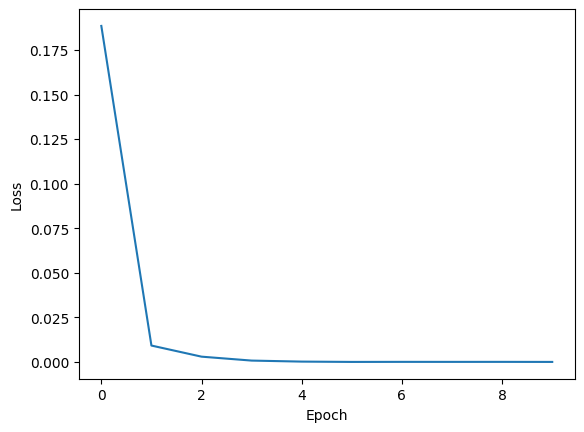

In [50]:
plt.plot(range(epochs), losses)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()


In [51]:
def preprocess_message(message, vectorizer):
    message_vectorized = vectorizer.transform([message])
    message_tensor = torch.tensor(message_vectorized.toarray(), dtype=torch.float32)
    return message_tensor

def predict_message(model, message_tensor):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        output = model(message_tensor)
        prediction = (output > 0.5).float().item()
    return prediction

new_message = "Congratulations! You've won a $1000 Walmart gift card. Go to http://scamwebsite.com to claim now."
message_tensor = preprocess_message(new_message, vectorizer)
prediction = predict_message(model, message_tensor)
result = 'scam' if prediction == 1 else 'not scam'
print(f"The message '{new_message}' is classified as: {result}")

non_scam_message = "Hi, I'll be home by 6 PM. See you then!"
message_tensor = preprocess_message(non_scam_message, vectorizer)
prediction = predict_message(model, message_tensor)
result = 'scam' if prediction == 1 else 'not scam'
print(f"The message '{non_scam_message}' is classified as: {result}")


The message 'Congratulations! You've won a $1000 Walmart gift card. Go to http://scamwebsite.com to claim now.' is classified as: scam
The message 'Hi, I'll be home by 6 PM. See you then!' is classified as: scam


In [53]:
# Check class balance
print(data['is_scam'].value_counts())


is_scam
0    145
1     55
Name: count, dtype: int64
